<a href="https://colab.research.google.com/github/vijay-ravi/llm-projects/blob/main/aws-bedrock/02_Exploring_AWS_Bedrock_Titan_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# AWS: Exploring the 5 Bedrock Titan Models






1.   **Import Libraries**
2.   **Initial Setup**
        *   Load documents from web
        *   Split into chunks
        *   Pull prompt from langchain hub
        *   Define our query we pass to prompt
3.   **Exploring the 5 Titan Models**
        * `amazon.titan-embed-text-v1`
        * `amazon.titan-text-lite-v1`  
        * `amazon.titan-text-express-v1`
        * `amazon.titan-embed-image-v1`
        * `amazon.titan-image-generator-v1`





Tutorial created by @[vijayxtech](https://beacons.ai/vijayxtech). Follow for more projects and guidance. **🤖**

![picture](https://img1.wsimg.com/isteam/ip/9ef33804-39fa-4619-913a-87a9f3820fde/alchemyrefiner_alchemymagic_0_36045e9a-de11-4.jpeg/:/cr=t:0%25,l:0%25,w:100%25,h:100%25/rs=w:1280)

## Import Libraries

In [ ]:
!pip install -q langchain langchain-community langchainhub chromadb bs4 langchain-experimental boto3 faiss-cpu gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 525.5/525.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.6/171.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import base64
import boto3
import io
import json
import os
import uuid
from IPython.display import display, Image as IPyImage
from PIL import Image
from typing import Any, List, Optional

from bs4 import BeautifulSoup as bs4

from langchain import hub
from langchain.chains import RetrievalQA
from langchain.embeddings import BedrockEmbeddings
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.llms import Bedrock
from langchain_community.vectorstores import Chroma, FAISS


## 2. Enter AWS Credentials

> Create access key and secret access key here:<br>
 https://us-east-1.console.aws.amazon.com/iam/home?region=us-east-1#/security_credentials

> Optional: <br>
Get your LangSmith API Key here: https://smith.langchain.com/

In [ ]:

os.environ["AWS_ACCESS_KEY_ID"] = "<insert-aws-access-key-id>"
os.environ["AWS_SECRET_ACCESS_KEY"] = "<insert-aws-secret-access-key>"
os.environ["AWS_DEFAULT_REGION"] = "us-east-1"

## Optional
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_PROJECT"] = "Bedrock Titan"
# os.environ["LANGCHAIN_API_KEY"] = "<insert-api-key>"

## Initial Setup:

Note: Feel free to change the `blog_url` and `query`.




In [ ]:
blog_url = "https://seo.ai/blog/ai-replacing-jobs-statistics/"
query = "Will human workers be replaced by AI by the year 2030?"

loader = WebBaseLoader(
    web_paths=(blog_url,),
)

text_splitter = RecursiveCharacterTextSplitter(chunk_size=400, chunk_overlap=100)
docs = loader.load_and_split(text_splitter)

## Pull the below prompt from the langsmith hub
## https://smith.langchain.com/hub

prompt = hub.pull("rlm/rag-prompt")



print('***********## PROMPT ##******************')
print(prompt)
print('\n')
print('*****************## DOCS ##******************')
print(docs[0])


***********## PROMPT ##******************
input_variables=['context', 'question'] messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['context', 'question'], template="You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:"))]


*****************## DOCS ##******************
page_content='AI Replacing Jobs Statistics: The Impact on Employment in 2024' metadata={'source': 'https://seo.ai/blog/ai-replacing-jobs-statistics/', 'title': 'AI Replacing Jobs Statistics: The Impact on Employment in 2024', 'description': 'Discover the current impact of AI on employment and the future challenges ahead. Explore AI replacing jobs statistics and industry perspectives.', 'language': 'No language found.'}


## ** IMPORTANT **: Request access for Bedrock models from below link: ##

https://us-east-1.console.aws.amazon.com/bedrock/home?region=us-east-1#/modelaccess

![alt text](http://drive.google.com/uc?export=view&id=1VXJJmyYqqdltq9wY1858K5MxNGKAtNqz)

## 1. Model: `amazon.titan-embed-text-v1`:

In [ ]:
embedding_model_id = "amazon.titan-embed-text-v1"

embeddings = BedrockEmbeddings(model_id=embedding_model_id)

vectorstore = FAISS.from_documents(docs, embeddings)

retriever = vectorstore.as_retriever()

docs = vectorstore.similarity_search(query)

i = 1
for doc in docs:
  print('\n')
  print(f"{i}. {doc.page_content}")
  i+= 1




1. the present impact is somewhat more restrained than the anticipation.Half of businesses have indeed integrated AI into their operations, signifying the technology's growing presence. However, the majority of businesses foresee computers replacing human tasks within 50 years, highlighting that while AI is a reality, it has not fully realized its potential for job replacement just yet.Moreover, the


2. might be overtaken by AI by 2030 adds an extra layer of complexity to this narrative.The Reality Check: Where Do We Stand Now?In contrast to these colossal expectations, our current situation paints a more measured picture. 14% of workers have experienced job displacement due to AI, suggesting that the present impact is somewhat more restrained than the anticipation.Half of businesses have indeed


3. AI is a reality, it has not fully realized its potential for job replacement just yet.Moreover, the influence of AI extends beyond employment statistics. It presents a formidable challe

##2. Model: `amazon.titan-text-lite-v1`


In [ ]:
model_id = "amazon.titan-text-lite-v1"

model_kwargs =  {
    "temperature": 0.8,
}

llm = Bedrock(
    model_id= model_id,
    model_kwargs=model_kwargs
)


qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt},
    verbose=False,
    return_source_documents=True,
)

result = qa_chain({"query": query})

i = 1
print(f"Question: {query}")
print('\n')
print(f"Response: {result['result']}")
print('\n')
print("Source Documents: ")
for doc in result["source_documents"]:
  print(f"{i}. {doc.page_content}")
  i+= 1

Question: Will human workers be replaced by AI by the year 2030?


Response: 
There is uncertainty regarding the extent to which AI will replace human workers by 2030. While some experts predict a significant impact, others are more reserved. The reality is that the integration of AI in various industries is ongoing, and its potential impact on jobs is complex.


Source Documents: 
1. the present impact is somewhat more restrained than the anticipation.Half of businesses have indeed integrated AI into their operations, signifying the technology's growing presence. However, the majority of businesses foresee computers replacing human tasks within 50 years, highlighting that while AI is a reality, it has not fully realized its potential for job replacement just yet.Moreover, the
2. might be overtaken by AI by 2030 adds an extra layer of complexity to this narrative.The Reality Check: Where Do We Stand Now?In contrast to these colossal expectations, our current situation paints a more mea

##3. Model: `amazon.titan-text-express-v1`

In [ ]:
model_id = "amazon.titan-text-express-v1"

model_kwargs =  {
    "temperature": 0.8,
}

llm = Bedrock(
    model_id= model_id,
    model_kwargs=model_kwargs
)


qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type_kwargs={"prompt": prompt},
    verbose=False,
    return_source_documents=True,
)

result = qa_chain({"query": query})

i = 1
print(f"Question: {query}")
print('\n')
print(f"Response: {result['result']}")
print('\n')
print("Source Documents: ")
for doc in result["source_documents"]:
  print(f"{i}. {doc.page_content}")
  i+= 1

Question: Will human workers be replaced by AI by the year 2030?


Response:  No, but some jobs will be affected by AI.


Source Documents: 
1. the present impact is somewhat more restrained than the anticipation.Half of businesses have indeed integrated AI into their operations, signifying the technology's growing presence. However, the majority of businesses foresee computers replacing human tasks within 50 years, highlighting that while AI is a reality, it has not fully realized its potential for job replacement just yet.Moreover, the
2. might be overtaken by AI by 2030 adds an extra layer of complexity to this narrative.The Reality Check: Where Do We Stand Now?In contrast to these colossal expectations, our current situation paints a more measured picture. 14% of workers have experienced job displacement due to AI, suggesting that the present impact is somewhat more restrained than the anticipation.Half of businesses have indeed
3. AI is a reality, it has not fully realized its pot

##4. Model: `amazon.titan-embed-image-v1`
Note: This is multimodal model which can embed both text and image.

### 4.1 Text Embeddings

In [ ]:
embedding_model_id = "amazon.titan-embed-image-v1"

embeddings = BedrockEmbeddings(model_id=embedding_model_id)

vectorstore = FAISS.from_documents(docs, embeddings)

retriever = vectorstore.as_retriever()

docs = vectorstore.similarity_search(query)

i = 1
for doc in docs:
  print('\n')
  print(f"{i}. {doc.page_content}")
  i+= 1



-> AI is a reality, it has not fully realized its potential for job replacement just yet.Moreover, the influence of AI extends beyond employment statistics. It presents a formidable challenge in the context of pandemic recovery, potentially hindering the restoration of 42% of job losses incurred during these unprecedented times.Want more statistics? Read this: Top 65 Artificial Intelligence


-> the present impact is somewhat more restrained than the anticipation.Half of businesses have indeed integrated AI into their operations, signifying the technology's growing presence. However, the majority of businesses foresee computers replacing human tasks within 50 years, highlighting that while AI is a reality, it has not fully realized its potential for job replacement just yet.Moreover, the


-> the present realities and contemplating future challenges.However, before we dig into the raw statistics, we'll provide a short analysis of the current impact of AI on human employment.Expected 

### 4.2 Image Embeddings

#### Download cars damage dataset
NOTE: If you get an `error`, download directly from the links below:<br>
https://drive.google.com/drive/folders/1zkKDzjpDCFg_thNxWoNh-xL6Ji2UNebw?usp=sharing

https://github.com/vijay-ravi/llm-projects/tree/main/aws-bedrock/cars_dataset

In [ ]:
import gdown
gdown.download_folder(url="https://drive.google.com/drive/folders/1zkKDzjpDCFg_thNxWoNh-xL6Ji2UNebw?usp=sharing",
                      quiet=True,
                      remaining_ok=True)

['/content/cars_dataset/test/Audi/176.jpg',
 '/content/cars_dataset/test/Audi/604.jpg',
 '/content/cars_dataset/test/Audi/610.jpg',
 '/content/cars_dataset/test/Audi/837.jpg',
 '/content/cars_dataset/test/Audi/1347.jpg',
 '/content/cars_dataset/test/Mahindra Scorpio/63.jpg',
 '/content/cars_dataset/test/Mahindra Scorpio/88.jpg',
 '/content/cars_dataset/test/Mahindra Scorpio/89.jpg',
 '/content/cars_dataset/test/Mahindra Scorpio/188.jpg',
 '/content/cars_dataset/test/Mahindra Scorpio/348.jpg',
 '/content/cars_dataset/test/Rolls Royce/48.jpg',
 '/content/cars_dataset/test/Rolls Royce/88.jpg',
 '/content/cars_dataset/test/Rolls Royce/176.jpg',
 '/content/cars_dataset/test/Rolls Royce/228.jpg',
 '/content/cars_dataset/test/Rolls Royce/361.jpg',
 '/content/cars_dataset/train/Audi_77.jpg',
 '/content/cars_dataset/train/Audi_189.jpg',
 '/content/cars_dataset/train/Audi_638.jpg',
 '/content/cars_dataset/train/Audi_823.jpg',
 '/content/cars_dataset/train/Audi_1353.jpg',
 '/content/cars_dataset/

In [ ]:
## Inspired from :
# https://medium.com/@dminhk/image-search-with-amazon-titan-multimodal-embeddings-and-mongodb-atlas-vector-search-afd7d7289682


# Calls Amazon Bedrock to get a vector from either an image, text, or both
def get_multimodal_vector(input_image_base64=None, input_text=None):
    bedrock = boto3.client(service_name='bedrock-runtime')
    request_body = {}
    if input_text:
        request_body["inputText"] = input_text
    if input_image_base64:
        request_body["inputImage"] = input_image_base64
    request_body["embeddingConfig"] = {"outputEmbeddingLength": 384}
    body = json.dumps(request_body)
    response = bedrock.invoke_model(
        body=body,
        modelId="amazon.titan-embed-image-v1",
        accept="application/json",
        contentType="application/json"
    )
    response_body = json.loads(response.get('body').read())
    embedding = response_body.get("embedding")
    return embedding

# creates a vector from an image file path
def get_vector_from_file(file_path):
    with open(file_path, "rb") as image_file:
        input_image_base64 = base64.b64encode(image_file.read()).decode('utf8')
    vector = get_multimodal_vector(input_image_base64 = input_image_base64)
    return vector

# embed query testing for an image
embeddings = get_vector_from_file('/content/cars_dataset/test/Audi/176.jpg')
print(len(embeddings)) # length of embedding dimensions = 1 x 384
print(embeddings[:5])  # only include the first 5 elements

384
[0.041744858, 0.09400324, -0.027829906, 0.056587476, 0.048547726]


In [ ]:

def encode_image(uri: str) -> str:
    """Encode image to base64 string."""
    with open(uri, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

def display_image_from_base64(base64_str: str):
    """Display image from base64 string in Jupyter notebook."""
    img = Image.open(io.BytesIO(base64.b64decode(base64_str)))
    display(img)

## Extending the Chroma class from LangChain
class NewChroma(Chroma):
    def add_images(self, uris: List[str], metadatas: Optional[List[dict]] = None, ids: Optional[List[str]] = None, **kwargs: Any) -> List[str]:
        b64_texts = [encode_image(uri) for uri in uris]
        if ids is None:
            ids = [str(uuid.uuid1()) for _ in uris]
        embeddings_list = [get_vector_from_file(uri) for uri in uris]

        try:
            self._collection.upsert(
                embeddings=embeddings_list,
                documents=b64_texts,
                ids=ids,
            )
        except ValueError as e:
            raise e
        return ids

## Creating a collection in Chroma and adding the image embeddings
vector_store = NewChroma(collection_name='car_damage_coll')

image_folder = 'cars_dataset/train'
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]
image_paths = [os.path.join(image_folder, f) for f in image_files]

vector_store.add_images(uris=image_paths, metadatas=[{"image_name": "cars.jpg"}])

print(f"There are {vector_store._collection.count()} images in the collection.")


****************########### INPUT IMAGE #############*****************



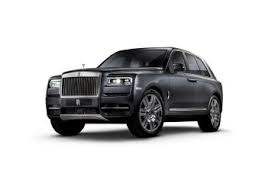


****************########### RESULTS #############*****************



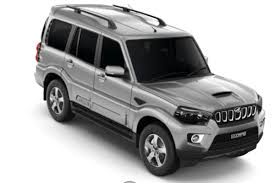

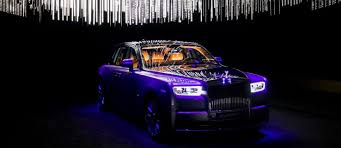

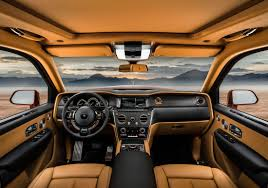

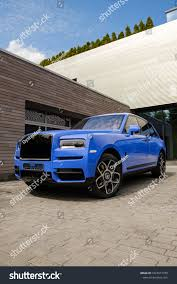

In [ ]:
## Test with an image

query_image = '/content/cars_dataset/test/Rolls Royce/176.jpg'

print("****************########### INPUT IMAGE #############*****************\n")
display(IPyImage(filename=query_image))

img_embedding_test = get_vector_from_file(query_image)
documents = vector_store.similarity_search_by_vector(img_embedding_test)

print("\n****************########### RESULTS #############*****************\n")
for doc in documents:
    display_image_from_base64(doc.page_content)

##5. Model: `amazon.titan-image-generator-v1`

In [ ]:
import json
import boto3
from PIL import Image
import io, base64
from IPython.display import display

bedrock = boto3.client('bedrock-runtime', 'us-east-1')
model_id = 'amazon.titan-image-generator-v1'

def image_generator(question):
    """
    This function takes in the user input requesting an image, invokes the LLM through Amazon Bedrock to generate
    an image to be displayed inline in a Google Colab notebook.
    :param question: This is the user request that contains text input describing the user's requested image.
    """
    body = json.dumps({
        "taskType": "TEXT_IMAGE",
        "textToImageParams": {"text": question},
        "imageGenerationConfig": {
            "numberOfImages": 1,
            "quality": "standard",
            "cfgScale": 8.0,
            "height": 512,
            "width": 512,
        },
    })

    accept = 'application/json'
    contentType = 'application/json'

    response = bedrock.invoke_model(body=body, modelId=model_id, accept=accept, contentType=contentType)
    response_body = json.loads(response["body"].read())
    base64_image_data = response_body["images"][0]

    img = Image.open(io.BytesIO(base64.b64decode(base64_image_data)))
    display(img)  # This line displays the image inline in the notebook


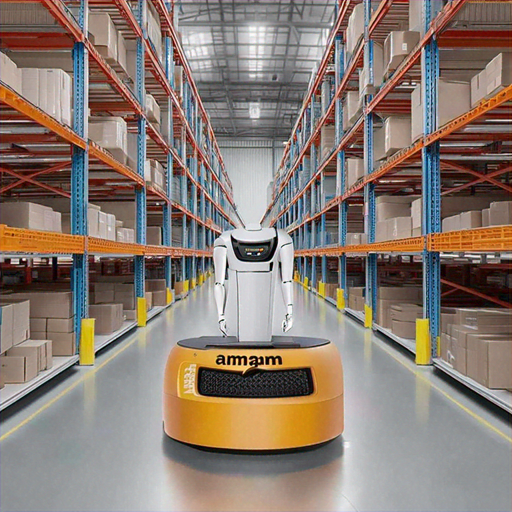

In [ ]:
## Generate image with prompt

image_generator("Generate me an image of a robot in an amazon warehouse.")